# 1. Basics of brain network modeling and running an example simulation

## A primer on brain network modeling

A neural mass model (NMM) mathematically represents the behavior and dynamics of a local population of neurons, abstracted into interacting neuronal ensembles that can model the activity of a brain area (node). A brain network model (BNM) is built by connecting brain areas—each modeled by an NMM—via a connectome. This connectome is often represented by a structural connectivity (SC) matrix, which quantifies the strength of white matter connections between different regions. Through the connectome, nodes (NMMs) influence each other’s activity while maintaining their local dynamics. As a result, a BNM can simulate the dynamics of the entire brain or a part of it (e.g. the cerebral cortex).

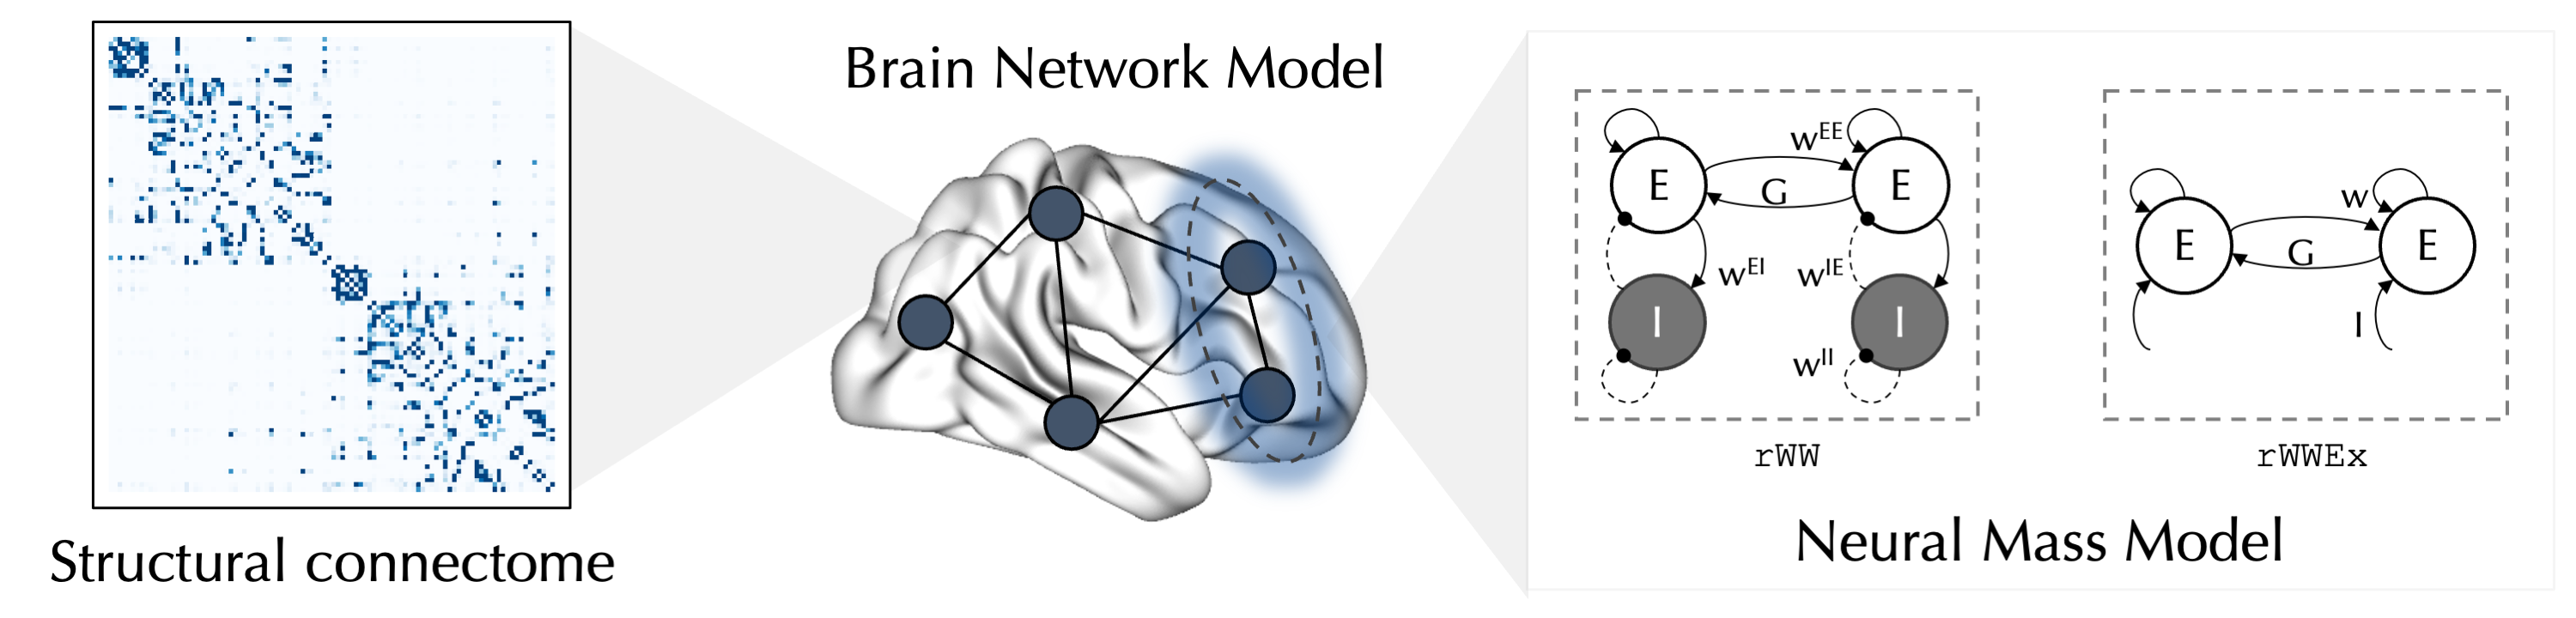

These simulations can be used in theoretical studies to investigate, *in silico*, how different model characteristics and parameters influences the resulting dynamics. Another main aim of studies using BNMs is to generate simulations that are most fitting to the empirical data obtained from a subject or a group of subjects, thereby creating a BNM that reflects that subject/group. This will require that an additional forward model that transforms the simulated NMMs activity to the type of empirical data obtained from the subjects. A very common type of the empirical data that is used for this purpose (and is supported by the toolbox), is the blood-oxygen-level-dependent (BOLD) signal measured during resting-state functional magnetic resonance imaging. The Balloon-Windkessel model of hemodynamics can be used to simulate BOLD signal in each node based on the simulated activity of its NMM. The simulated BOLD signal can then be compared with the empirical BOLD signal to assess its goodness-of-fit (GOF). Two measures commonly used to assess GOF include:

- Pearson correlation of simulated and empirical functional connectivity (FC) matrices. FC matrix is calculated as the correlation of (simulated/empirical) BOLD signal time series between nodes.
- Similarity of FC dynamics, measured as Kolmogorov-Smirnov distance of the distribution of values within simulated versus empirical functional connectivity dynamics (FCD) matrices. FCD matrix is constructed by calculating the correlation of dynamic FC patterns between sliding windows of (simulated/empirical) BOLD signal. The size and step of these sliding windows can be defined in the toolbox.

## Reduced Wong-Wang BNM

When constructing a BNM, several decisions need to be made, including: i. the choice of NMM that describe the activity of each node, ii. the definition of nodes (the choice of atlas and the areas to include), and iii. the choice of connectome (i.e., from a template, group-averaged data, or subject-specific SCs).

In this tutorial we will show an example of a BNM constructed from the reduced Wong-Wang (rWW) NMM [[Deco et al. 2014](https://doi.org/10.1523/JNEUROSCI.5068-13.2014)], using Scheafer parcellation with 100 cortical nodes and by using the example SC included in the toolbox. We will then show how the resulting example simulation compares to real (empirical) resting-state fMRI BOLD data.

In the rWW model, as shown in the figure above, each node (NMM) consists of an excitatory (E) and an inhibitory (I) neuronal population which are connected through a set of weights: $w^{EE}$ (recurrent excitatory connection weight), $w^{EI}$ (excitatory to inhibitory connection weight), $w^{IE}$ (inhibitory to excitatory connection weight) and $w^{II}$ (recurrent inihibitory connection weight). The nodes are connected to each other through their E neuronal ensembles and based on the strength of SC between them ($C_{ij}$) scaled by a parameter $G$ (global coupling). In addition, to model influence of stochastic fluctuations on the node dynamics, Gaussian noise is injected into the model. Here is the system of differntial equations describing the rWW BNM:

$I_i^E\left(t\right)=W^EI_b+w_i^{EE}S_i^E\left(t\right)+GJ_{NMDA}\sum_{j}^{N}{C_{ij}S_j^E\left(t\right)}-w_i^{IE}S_i^I(t)\ $

$I_i^I\left(t\right)=W^II_b+w_i^{EI}S_i^E\left(t\right)-w^{II}S_i^I\left(t\right)$

$r_i^E\left(t\right)=H^E(I_i^E)\ =\frac{a^EI_i^E(t)-b^E}{1\ -\ e^{-d^E(a^EI_i^E(t)-b^E)}}$

$r_i^I\left(t\right)=H^I(I_i^I)\ =\frac{a^II_i^I(t)-b^I}{1\ -\ e^{-d^I(a^II_i^I(t)-b^I)}}$

$\frac{dS_i^E(t)}{dt}=-\frac{S_i^E\left(t\right)}{\tau_E}+\left(1\ -\ S_i^E\left(t\right)\right)\gamma r_i^E\left(t\right)+\sigma\nu_i(t)$

$\frac{dS_i^I(t)}{dt}=-\frac{S_i^I\left(t\right)}{\tau_I}+r_i^I\left(t\right)+\sigma\nu_i(t)$

In this model (and in our implementation of it), while most of the model parameters are fixed, four are variable and can be tuned to alter the simulation: $G$, which is a global parameter (may vary across simulations), and $w_i^{EE}$, $w_i^{EI}$ and $w_i^{IE}$ which are regional parameters (may vary across simulations and nodes). While $G$, $w_i^{EE}$ and $w_i^{EI}$ are "free parameters" determined by the user (or optimization algorithm, more on this in the next tutorials), $w_i^{IE}$ is (by default) determined via "Feedback Inhibition Control" (FIC) algorithm which aims to maintain the firing rate of E neurons within a biologically plausible range of 3 Hz [[Deco et al. 2014](https://doi.org/10.1523/JNEUROSCI.5068-13.2014), [Demirtas et al. 2019](https://doi.org/10.1016/j.neuron.2019.01.017)]. In this tutorial we will show the simulation results first with, and then without FIC. Note that FIC is specific to rWW model and is not applied in the other models.

Given a set of candidate free parameters and a SC, the toolbox will numerically integrate the system of differential equations using Euler-Maruyama method, and generate simulated time series of all model states, including input current ($I$), firing rate ($r$) and synaptic gating ($S$) of E and I neuronal ensembles in each node. The simulated synaptic gating of the E population ($S_i^E$) is then fed to the Balloon-Windkessel model of hemodynamics to simulate BOLD signal, which is then sampled at intervals similar to the repetition time (TR) of the empirical BOLD.

## Run an example simulation of rWW BNM

We should first define the structural connectome (SC) that determines the presence and strength of connections between pairs of nodes. In the toolbox we have included an example SC matrix, which we will load and visualize:

<Axes: >

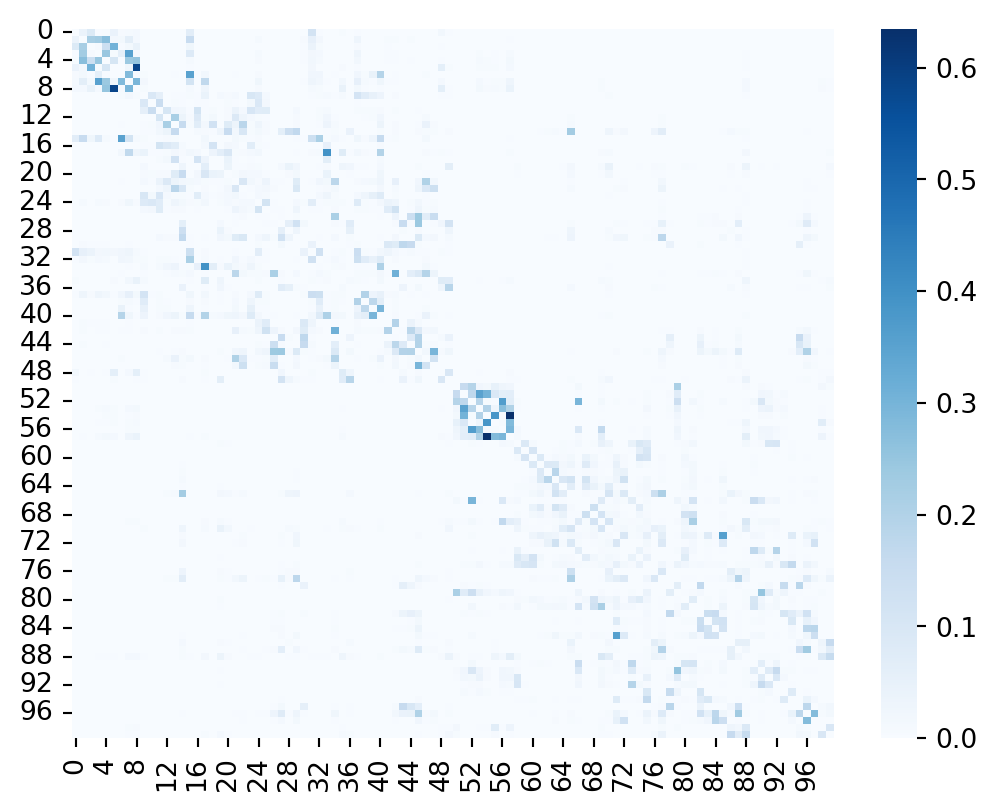

In [1]:
from cubnm import datasets
import seaborn as sns
import matplotlib.pyplot as plt

# set plots dpi to 192
plt.rcParams.update({"figure.dpi": 192})

# load structural connectome
sc = datasets.load_sc('strength', 'schaefer-100')

# plot it
sns.heatmap(sc, cmap='Blues')

<div class="alert alert-info">
<p>
    Note: To construct a subject-specific BNM diffusion weighted imaging (DWI) data can be used to create subject-specific SCs. DWI data can be processed into a SC matrix using tools such as [MRtrix](https://mrtrix.readthedocs.io/en/latest/) or its wrapper pipelines such as [Micapipe](https://micapipe.readthedocs.io/en/latest/).
</p>
</div>

Next, we construct a rWW BNM using this SC and define the simulation configurations. This is done by creating an instance of `cubnm.sim.rWWSimGroup` (``cubnm.sim.***SimGroup`` for other models) as follows:

In [2]:
from cubnm import sim

sim_group = sim.rWWSimGroup(
    duration=435,
    bold_remove_s=15,
    TR=0.6,
    sc=sc,
    sc_dist=None,
    dt='0.1',
    bw_dt='1.0',
    ext_out=True,
    states_ts=True,
    states_sampling=0.1,
    noise_out=False,
    rand_seed=421,
    noise_segment_length=30,
    gof_terms=['+fc_corr', '-fcd_ks'],
    do_fc=True,
    do_fcd=True,
    window_size=50,
    window_step=10,
    fcd_drop_edges=True,
    exc_interhemispheric=False,
    bw_params='heinzle2016-3T',
    sim_verbose=True,
    do_fic=True,
    max_fic_trials=0,
)

Here is a break down of the option:

- `duration` is set to 435 seconds, which corresponds to 420 seconds (7 minutes) similar to the empirical data in addition to 15 initial seconds that are needed for the model to stabilize (this initial 15 seconds is defined as `bold_remove_s` and is discarded before calculating FC, FCD or the average of state variables)
- `TR` is set to 0.6 seconds, corresponding to the empirical counterpart
- `sc` is set to the SC matrix we loaded above
- `sc_dist` refers to SC distance or length matrix which is (by default) set to `None`. If this matrix is provided there will be a conduction delay between the nodes as a factor of conduction velocity (the parameter `v`).
- `dt` is the integration step used in the NMM model (in msec). By default it is set to 0.1 msec. It has to be provided a `decimal.Decimal` object or a string (which will be converted to a `decimal.Decimal` object, rather than a floating point number, because of how Python stores floating point numbers and to ensure that `dt` is exactly set to 0.1.
- `bw_dt` is the integration step of the Balloon-Windkessel model (in msec) which is by default set to 1.0 msec.
- `ext_out` determines whether extended output, including NMM state variables ($I^E$, etc.) are stored and returned
- `states_ts` determines whether the NMM state variables should be stored as time series rather than their averages in each node
- `states_sampling` sets the rate (in seconds) of sampling the states in case `states_ts` is `True`. If not provided it will be set equal to `TR`.
- `noise_out` determines whether the noise array used in the simulation should be stored. By default it is set to `False` as the noise array is very large.
- `rand_seed` is the random seed used to generate Gaussian noise
- `noise_segment_length` is the length of the noise segment used in the simulation. This noise segment which is by default 30 seconds, will be repeated several times throughout the simulation with random reshuffling in each repeat. To generate noise for the entire length of the simulation, set this to `None` (but it is not recommended given large memory demands, see the technical note below).
- `gof_terms` are the terms used in GOF assessment, which by default include `+fc_corr` (aiming to increase FC correlation) and `-fcd_ks` (aiming to decrease FCD KS distance). In `gof_terms` positive sign indicates that we aim to increase the measure, and negative sign indicates the opposite.
- `do_fc` and `do_fcd` which are by default set to `True` indicate whether simulated FC and FCD in addition to simulated BOLD should be calculated. Note that FC and FCD calculations are also done efficiently and in parallel on GPUs (if available).
- `window_size`, `window_step` and `fcd_drop_edges` define how the moving windows should be determined in the calculation of dynamic FC which is then used to calculate the FCD matrix. `window_size` and `window_step` unit is the number of TRs, which we here set to 50 TRs (* 0.6 s/TR = 30 s) for window size and 10 TRs (* 0.6 s/TR = 6 seconds). We set `fcd_drop_edges` to `True` (which is also the default) to drop edge windows which include less than 50 TRs.
- `exc_interhemispheric` (default `False`) determines whether interhemispheric connections are excluded from the calculation of FC and FCD (but not from the SC). The reason to do so could be that interhemispheric connections are a bit under-represented in the SCs (especially when derived from lower-quality DWI) and that could negatively affect the process of fitting, by making it more difficult and susceptible to noise effects.
- `bw_params` sets the Balloon-Windkessel parameters which is by default set to `friston2003`, but here we set it to `heinzle2016-3T` which includes adapted parameters for 3T scanners, which was the type of scanner used for the empirical data.
- `sim_verbose` sets the verbosity of simulations, including printing additional info and the simulations progress. Note that currently progress cannot be shown in real time in Jupyter notebooks.
- The options so far are shared between all `cubnm.sim.SimGroup` derived classes for different models. The last two, `do_fic` and `max_fic_trials` are options that are specific to `rWW`
    - `do_fic` (default `True`) determines whether analytical (+ numerical) FIC should be done
    - `max_fic_trials` is by default set to 0. If it's > 0, analytical FIC is first done to estimate the initial $w_i^{IE}$ values, but then they are refined in trials of numerical FIC which involves repeating the first 10 seconds of the simulations for `max_fic_trials` trials or until FIC target is achieved. This will make the simulations slower since repeats are done.

See the [API](../autoapi/cubnm/sim/index.html) of `cubnm.sim.SimGroup` and `cubnm.sim.rWWSimGroup` for the full list of options and more details.

<div class="alert alert-info">
<p>
    Technical note: The reason for using noise segments rather than generating noise for the full length of the simulation is performance. Sampling Gaussian noise in real time while simulation is being run on the GPU will take time and reduce performance, and if we want to use the same noise array in all the parallel simulations that are being run, it would be a waste of compute power to redo this for every simulation. As a solution to this problem, we precalculate the noise on the CPU, then move it to GPU and use it in the model calculations. However, this precalculated noise array can get very large especially with increased demand (higher duration, number of nodes, or lower integration step), and can quickly grow larger than the amount of memory available on the GPU or CPU. To solve this issue, rather than precalculating the entire noise array, we precalculate a segment (by default with a duration of 30 seconds) and repeat it throughout the duration of the simulation (e.g. with duration = 435 s it will be repeated 15 times). But it should not be exactly repeated as it will create artificial patterns of repetition in the simulation. Rather, in each repeat the noise array is randomly (but reproducibly) reshuffled. If we view the noise segment as a matrix of (nodes, time points), the reshuffling is done by simultaneously shuffling across both nodes and time points.
</p>
</div>

We then specify the number of simulations (here a single one) and set its parameters to some (for now arbitrary) values. The parameters should be specified within the `sim_group.param_lists` dictionary. As mentioned before $G$ (`'G'`) is a global parameter and should be an array of (N simulations,) elements. On the other hand $w_i^{EE}$ (`'wEE'`) and $w_i^{EI}$ (`'wEI'`) (and also $w_i^{IE}$, but we don't set it here as it will be set via FIC) are regional parameters that can be variable across the nodes in each simulation, and should be arrays of (N simulations, N nodes) elements. However in this example we will assume that they are homogeneous across nodes (as has been the case in [Deco et al. 2014](https://doi.org/10.1523/JNEUROSCI.5068-13.2014) and other (earlier) papers using this model).

In [3]:
import numpy as np

# set number of simulations to 1
sim_group.N = 1
# set parameters
sim_group.param_lists['G'] = np.repeat(0.5, sim_group.N)
sim_group.param_lists['wEE'] = np.full((sim_group.N, sim_group.nodes), 0.21)
sim_group.param_lists['wEI'] = np.full((sim_group.N, sim_group.nodes), 0.15)

After defining the BNM, its configurations, number of simulations, and their parameters, we can now run the `sim_group` via its `sim_group.run()` method. Before that we'll ensure we have access to an Nvidia GPU on this machine. If there are no Nvidia GPUs the simulation will be done on CPU (note that for a single simulation with 100 nodes CPU and GPU time do not considerably differ).

In [4]:
from cubnm import utils

if utils.avail_gpus() > 0:
    print("Running the simulation on GPU")
else:
    print("No Nvidia GPUs found. Running the simulation on CPU")

sim_group.run()

Running the simulation on GPU
Initializing GPU session...

CUDA device #0: NVIDIA GeForce GTX 1080 Ti
Precalculating 60000000 noise elements...
noise will be repeated 15 times (nodes [rows] and timepoints [columns] will be shuffled in each repeat)
took 1.962463 s
Running 1 simulations...
nodes: 100
N_SIMS: 1
N_SCs: 1
BOLD_TR: 600
states_sampling: 100
time_steps: 435000
do_delay: 0
rand_seed: 421
exc_interhemispheric: 0
verbose: 1
progress_interval: 500
bold_remove_s: 15
drop_edges: 1
ext_out: 1
do_fc: 1
do_fcd: 1
states_ts: 1
noise_time_steps: 30000
serial: 0
100.00%
Simulation completed
took 64.554053 s


### Simulation output

After `sim_group.run()` is called the simulation output will be stored in the following attributes

- `sim_group.sim_bold`: Simulated BOLD time series. Shape: (N simulations, N BOLD volumes, N nodes)
- `sim_group.sim_fc_trils`: Lower triangles of simulated FCs (lower triangles are calculated and stored as FC is a symmetric matrix). Shape: (N simulations, N edges)
- `sim_group.sim_fcd_trils`: Lower triangles of simulated FCDs (lower triangles are calculated and stored as FCD is a symmetric matrix). Shape: (N simulations, N pair of dynamic FC windows)
- `sim_group.sim_states`: A dictionary of arrays for each of the six states. Each array has the shape (N simulations, N nodes) if `states_ts` is `False` (and averages are stored). Otherwise they will have the shape (N simulations, N samples, N nodes).

Additional outputs including `init_time` and `run_time`, in addition to `fic_ntrials`, `fic_failed` and `fic_unstable` (specific to rWW model), as well as data related to the noise array (if `noise_out` is `True`) are also stored after `.run()` is called. 

<div class="alert alert-info">
<p>
Note: If `noise_out` is `True`, after `.run()` is done the method `.get_noise()` can be used to get the entire array of noise used in the simulation including all the repeats which has the shape (N noise elements per NMM, N nodes, N Balloon-Windkessel time steps, N NMM time steps in each Balloon-Windkessel step). This can be used to check for example if the noise arrays across different nodes are correlated, or how much state time series and BOLD time series are affected by the noise.
</p>
</div>


We can then plot simulated state variables and BOLD for the first two nodes:

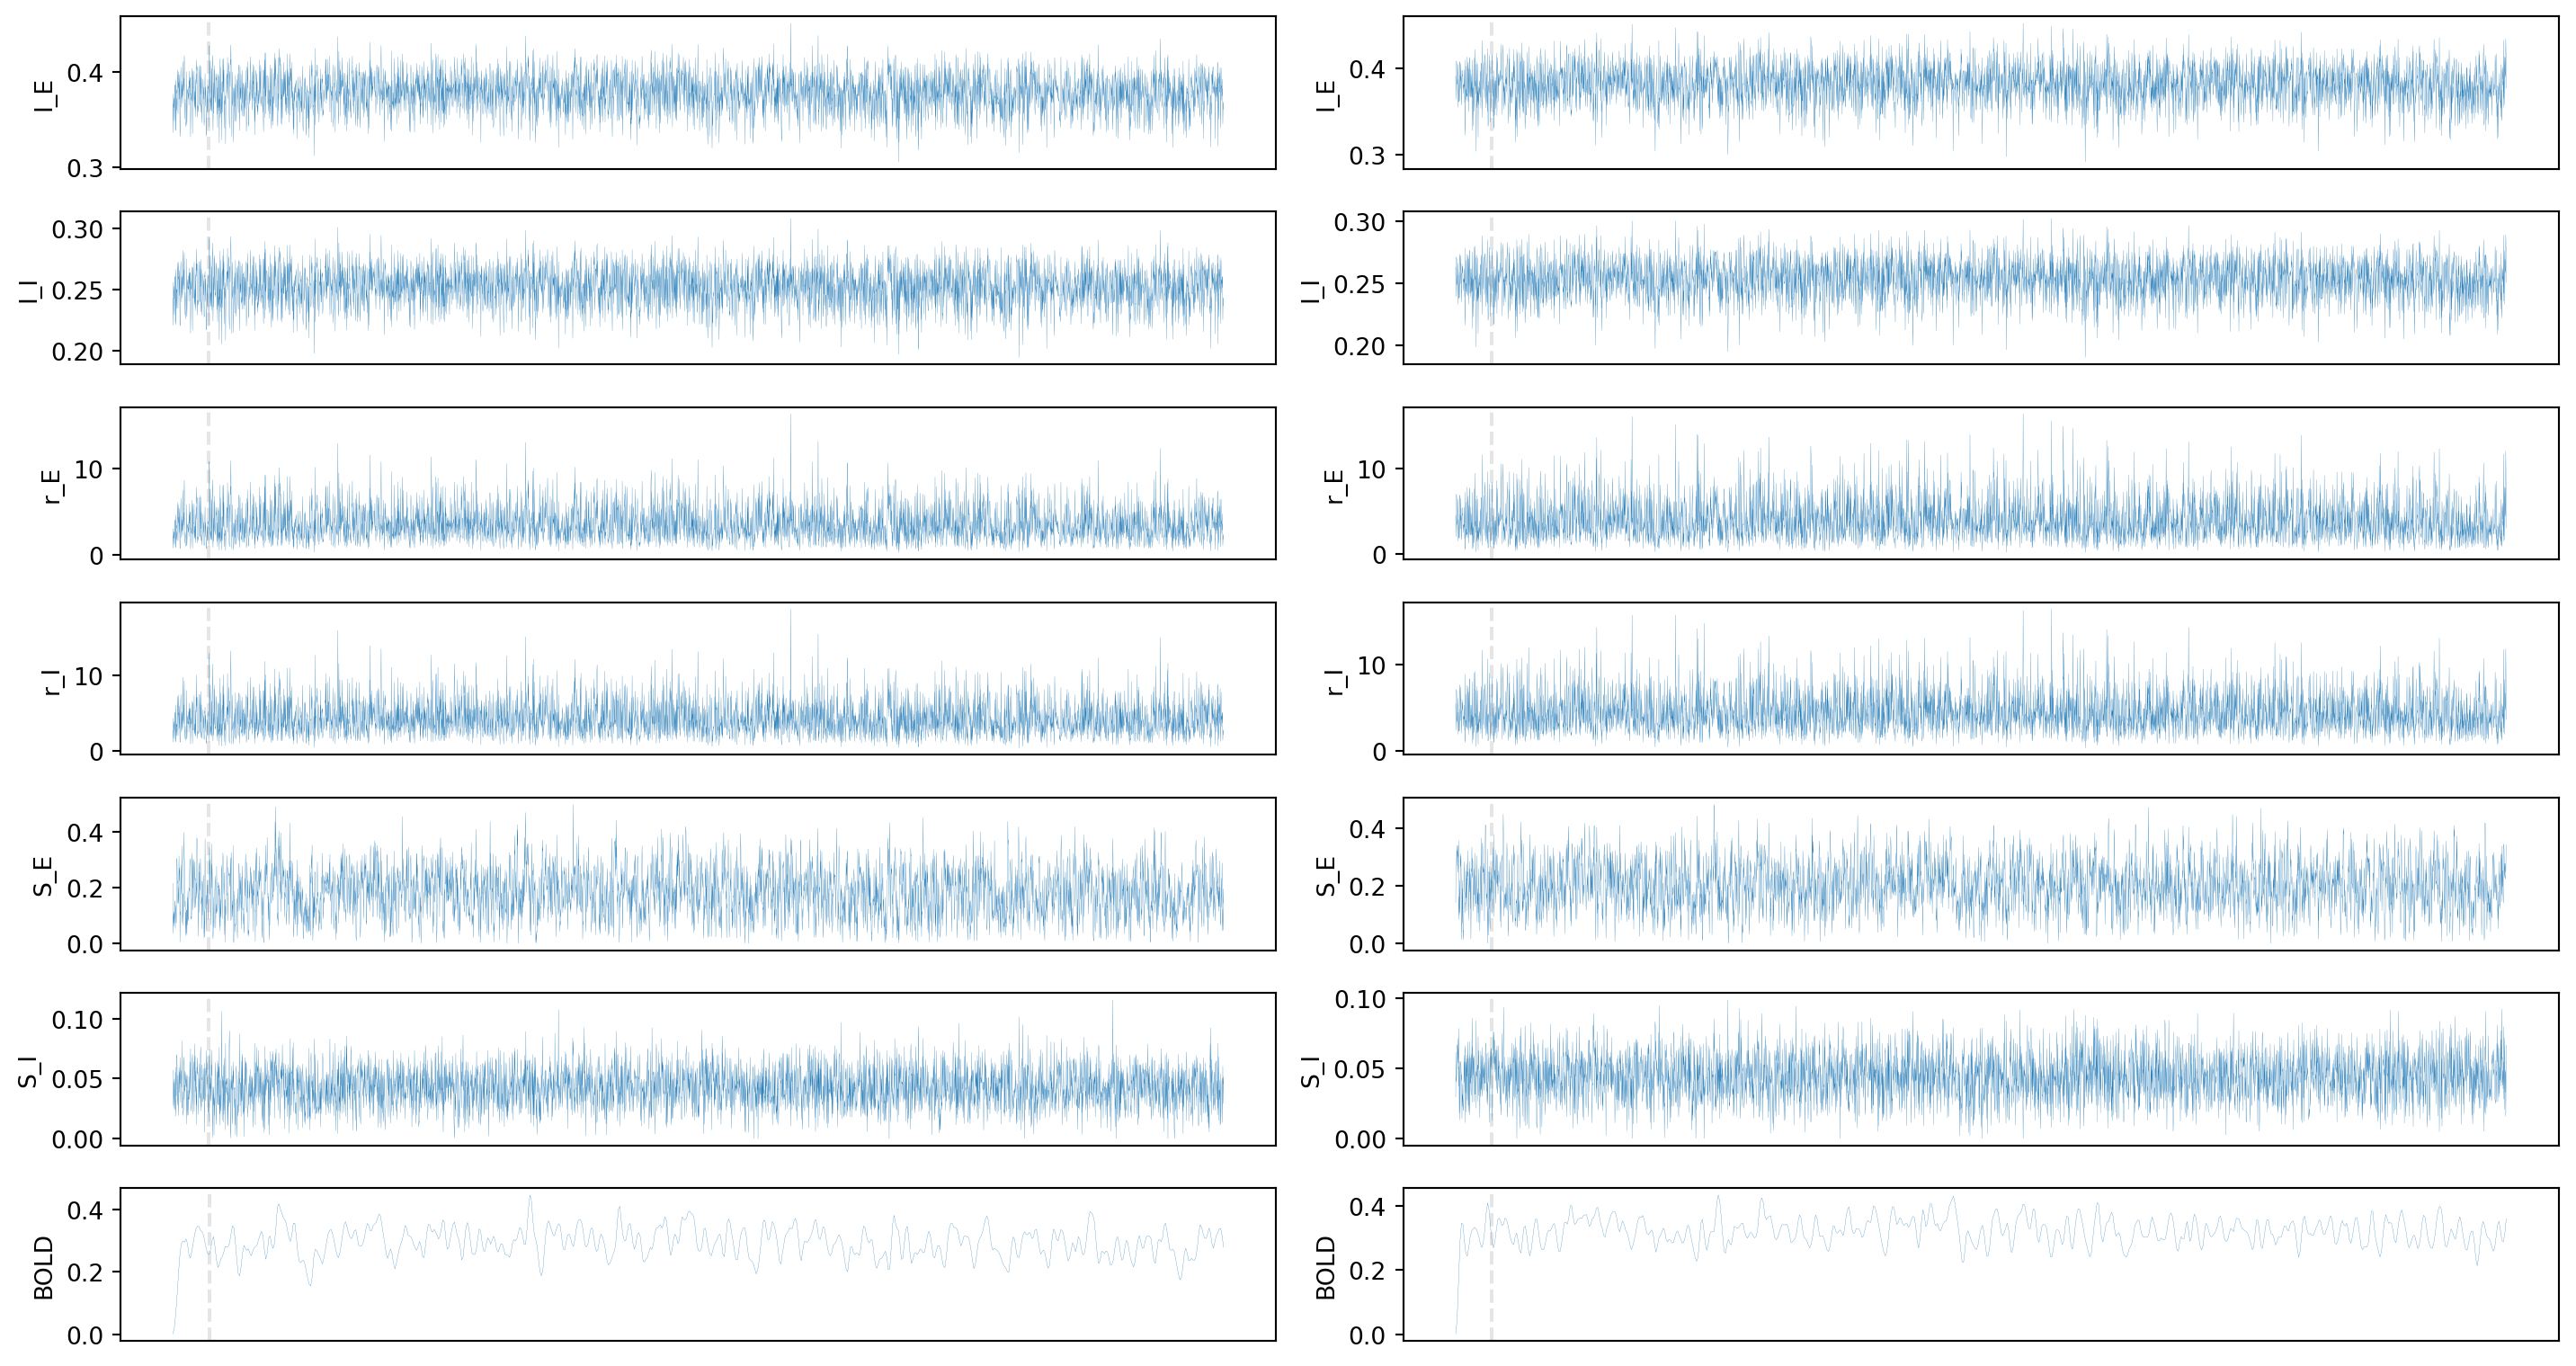

In [5]:
fig, axes = plt.subplots(7, 2, figsize=(15, 8))

for i, feature in enumerate(['I_E', 'I_I', 'r_E', 'r_I', 'S_E', 'S_I', 'BOLD']):
    for j in [0, 1]:
        if feature == 'BOLD':
            ts = sim_group.sim_bold[0, :, j]
        else:
            ts = sim_group.sim_states[feature][0, :, j]
        # plot timeseries
        axes[i, j].plot(ts, linewidth=0.1)
        # add t=15 line (the time before which was removed from FC and FCD calculations)
        if feature == 'BOLD':
            axes[i, j].axvline(sim_group.bold_remove_s // sim_group.TR, linestyle='--', color='grey', alpha=0.2)
        else:
            axes[i, j].axvline(sim_group.bold_remove_s // sim_group.states_sampling, linestyle='--', color='grey', alpha=0.2)
        axes[i, j].set_ylabel(feature)
        if i < len(ts)-1:
            axes[i, j].set_xticks([])
fig.tight_layout(pad=1)

Or visualize time series of all nodes using heat maps:

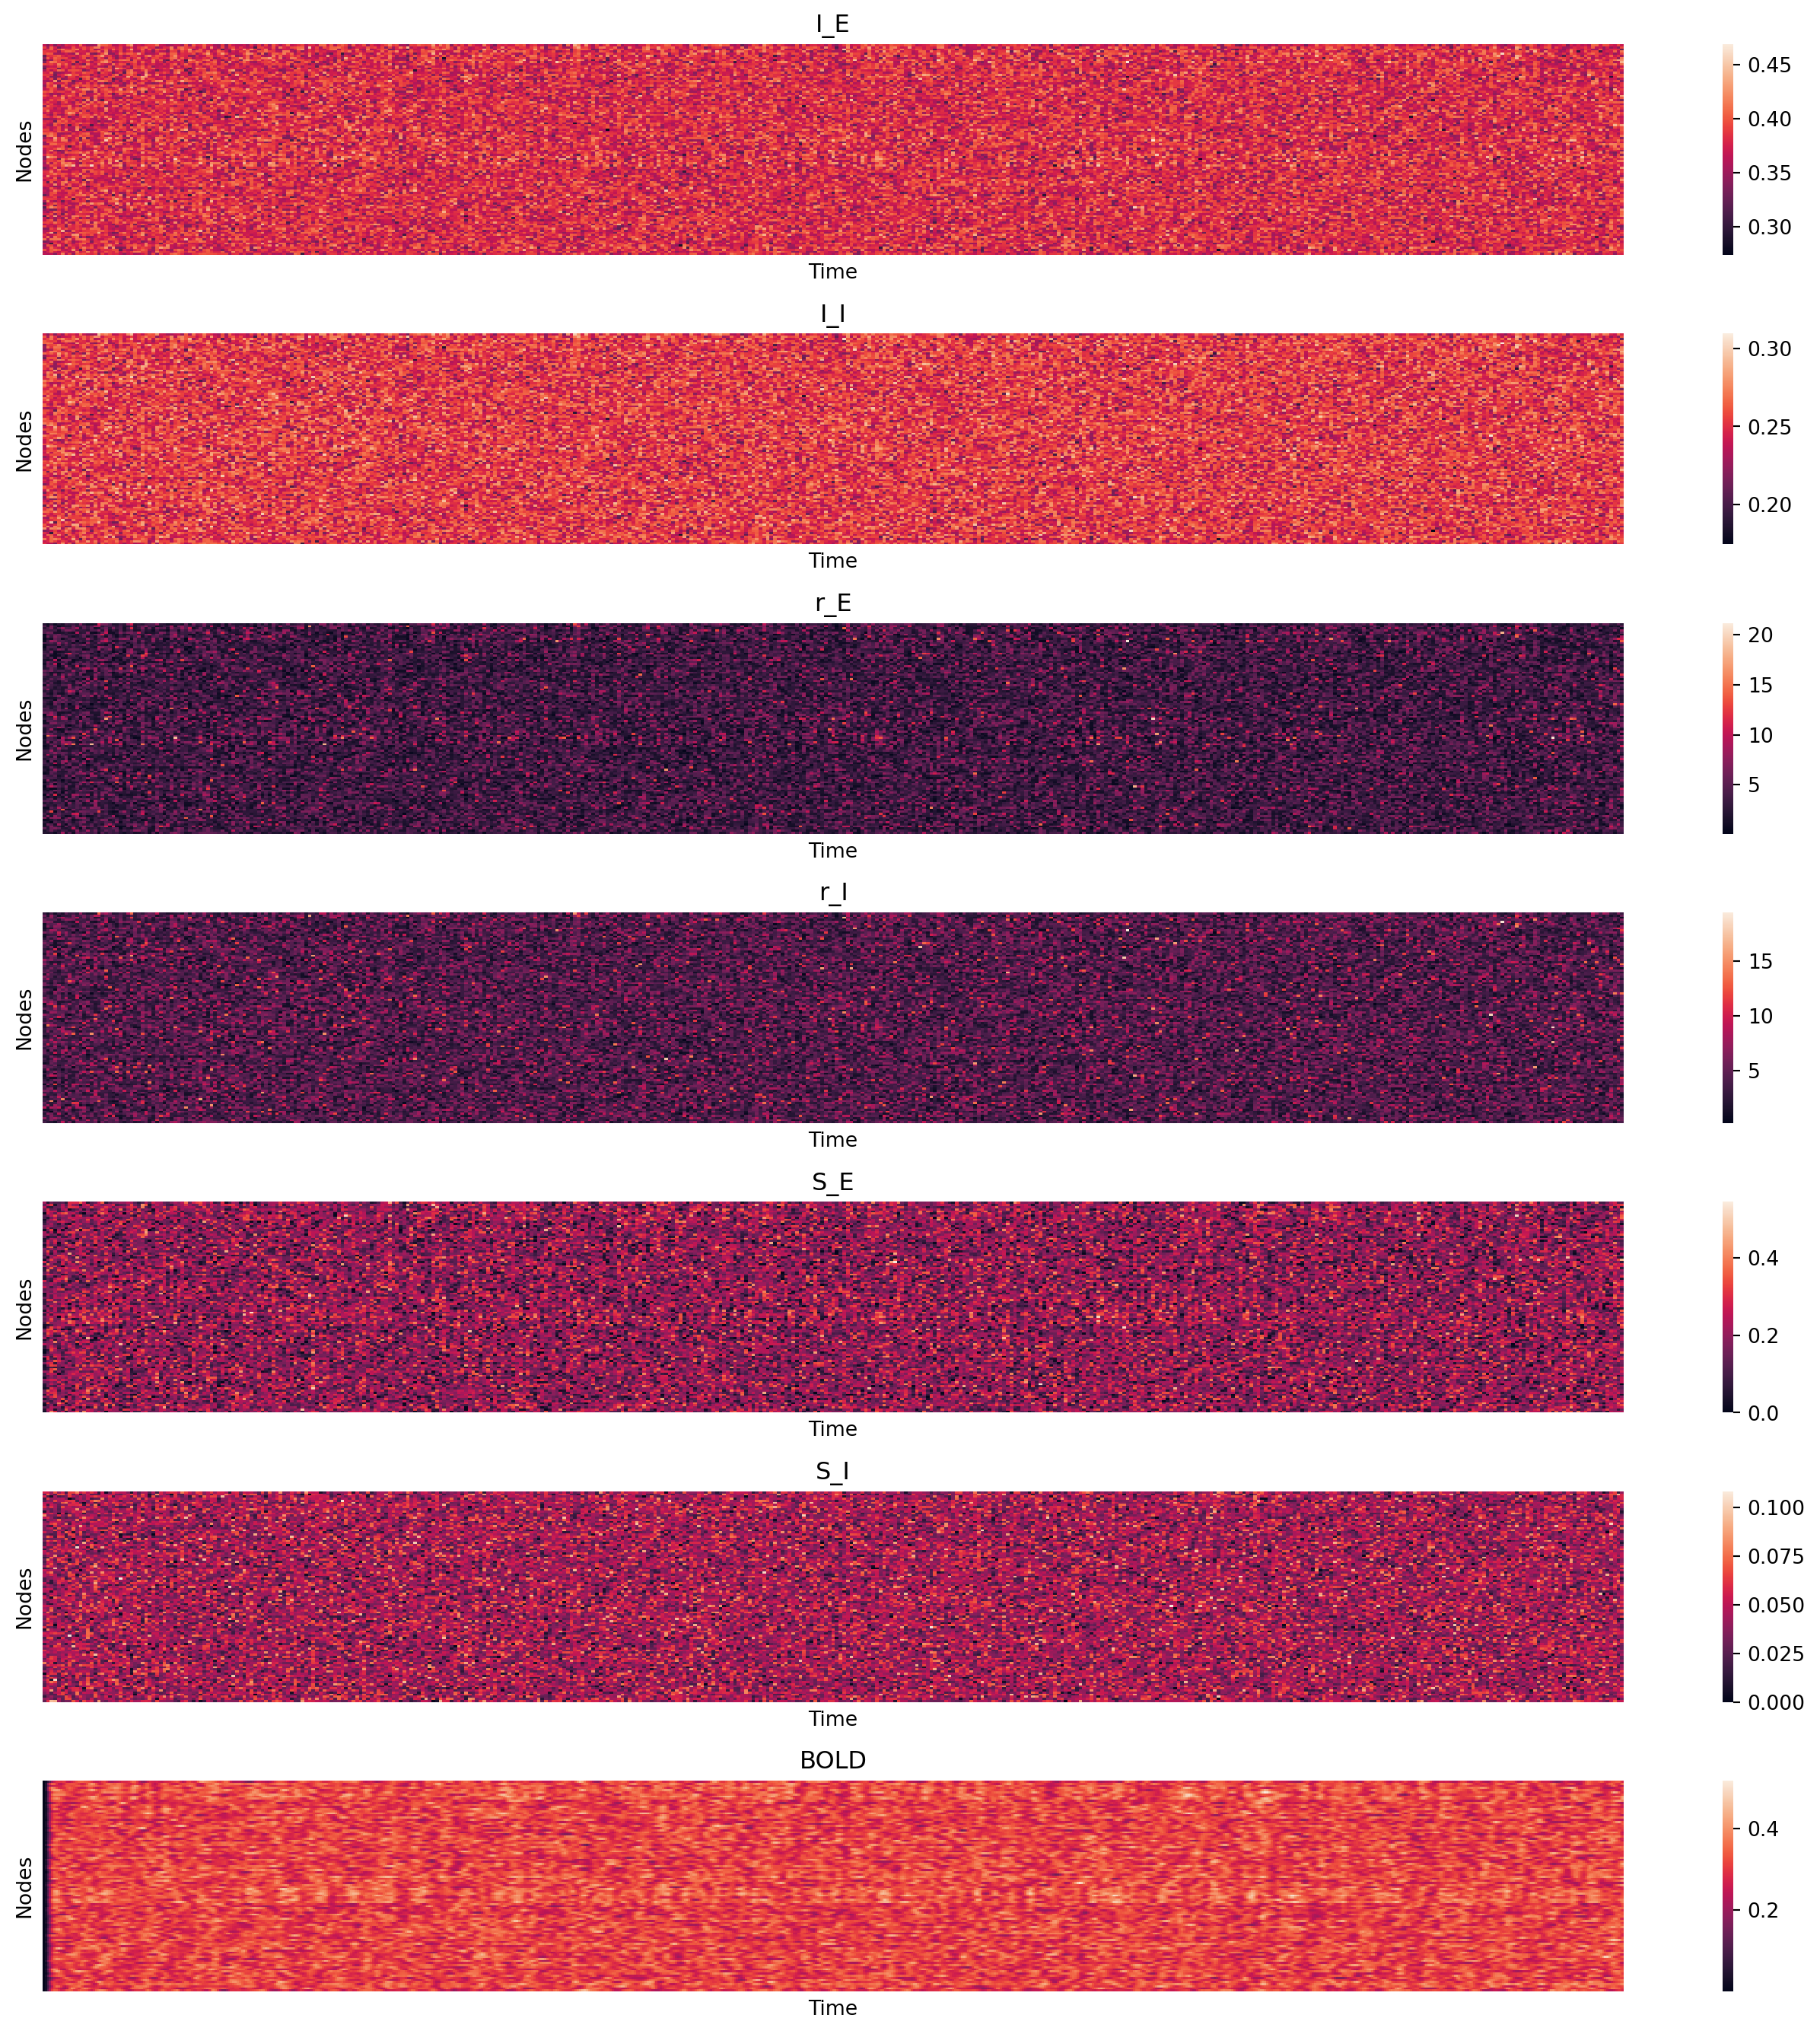

In [6]:
fig, axes = plt.subplots(7, 1, figsize=(14, 14))

for i, feature in enumerate(['I_E', 'I_I', 'r_E', 'r_I', 'S_E', 'S_I', 'BOLD']):
    if feature == 'BOLD':
        ts = sim_group.sim_bold[0, :].T
    else:
        ts = sim_group.sim_states[feature][0, ::10].T
    sns.heatmap(ts, ax=axes[i])
    axes[i].set_ylabel("Nodes")
    axes[i].set_xlabel("Time")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(feature)
fig.tight_layout(pad=1)

We can also plot the simulated FC. Note that as the lower triangle is stored FC should be converted to its full squared form before plotting.

<Axes: >

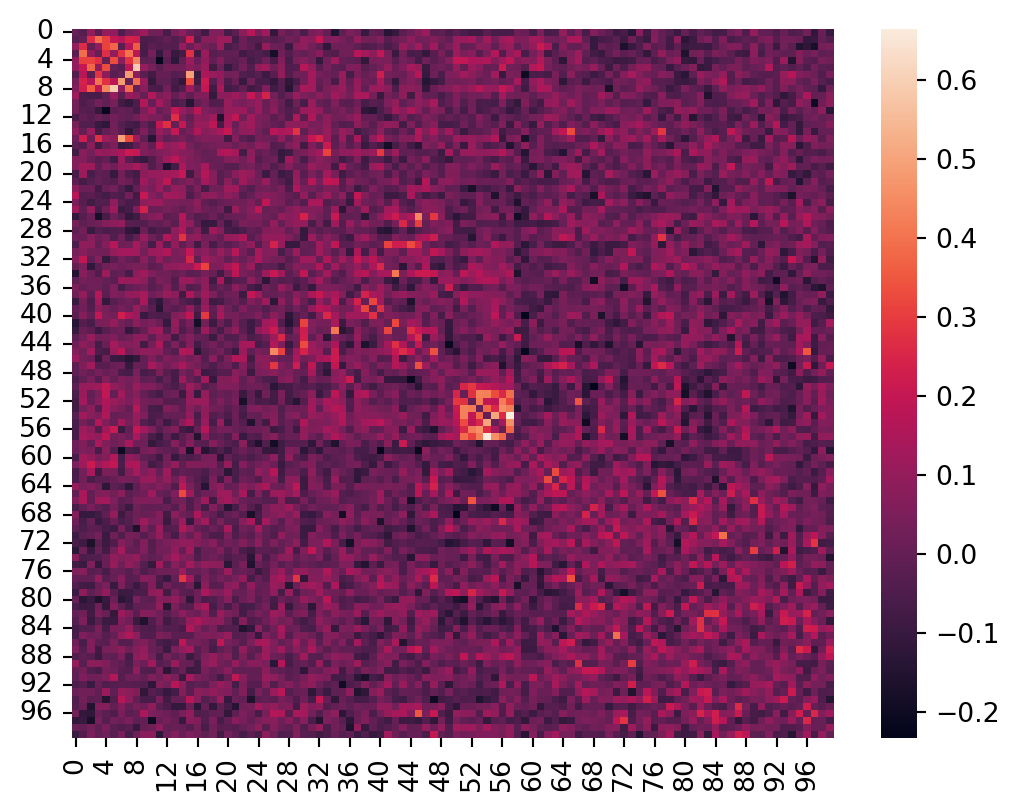

In [7]:
# construct full FC from the lower triangle which is stored in sim_group
sim_fc = np.zeros((sim_group.nodes, sim_group.nodes))
sim_fc[np.tril_indices_from(sim_fc, -1)] = sim_group.sim_fc_trils[0]
sim_fc += sim_fc.T

# plot it
sns.heatmap(sim_fc)

In addition, we can plot simulated FCD and its distribution. Note that again as FCD lower triangle is stored, to plot its matrix it should be converted to squared form (if we know number of windows), but it will be easier to recalculate FCD from the simulated BOLD. To do this, we can use the `cubnm.utils.calculate_fcd` function.

<Axes: >

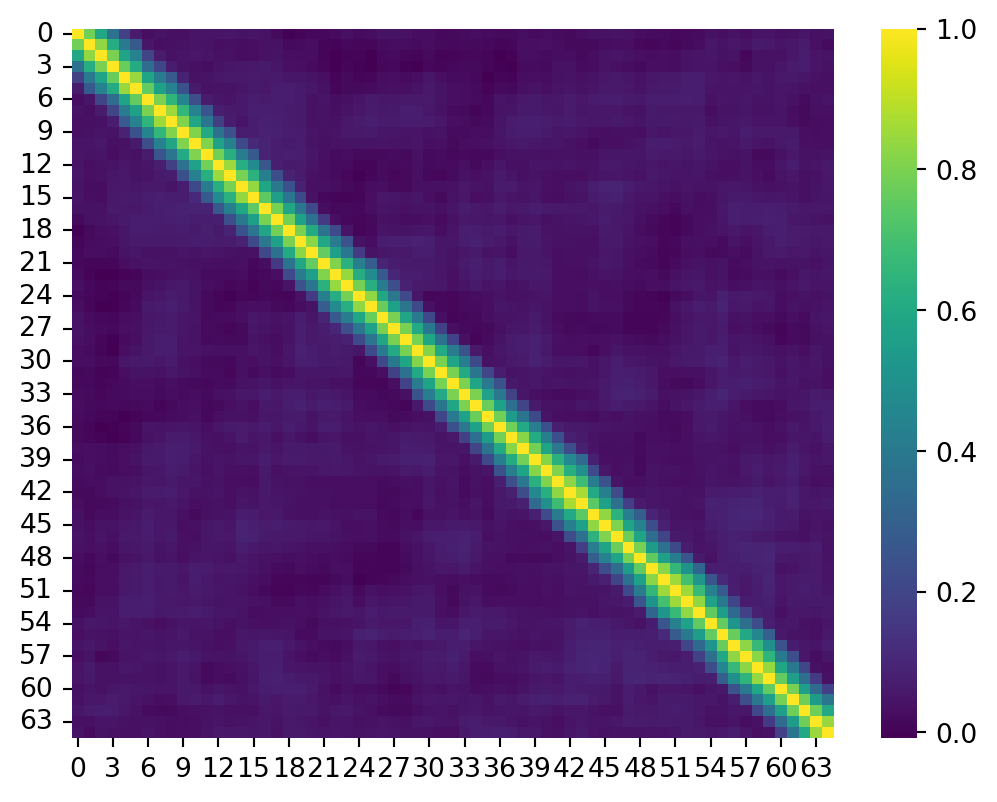

In [8]:
# calculate number of initial BOLD volumes to remove
bold_remove_vols = int(sim_group.bold_remove_s // sim_group.TR)
# recalculate simulated FCD based on BOLD
sim_fcd = utils.calculate_fcd(sim_group.sim_bold[0, bold_remove_vols:, :].T.copy(), window_size=50, window_step=10, return_tril=False)

# double check that its lower triangle is equal to the FCD lower triangle calculated
# on GPU via .run()
assert np.isclose(sim_group.sim_fcd_trils[0], sim_fcd[np.tril_indices_from(sim_fcd, -1)]).all()

# plot it
sns.heatmap(sim_fcd, cmap='viridis')

<Axes: ylabel='Count'>

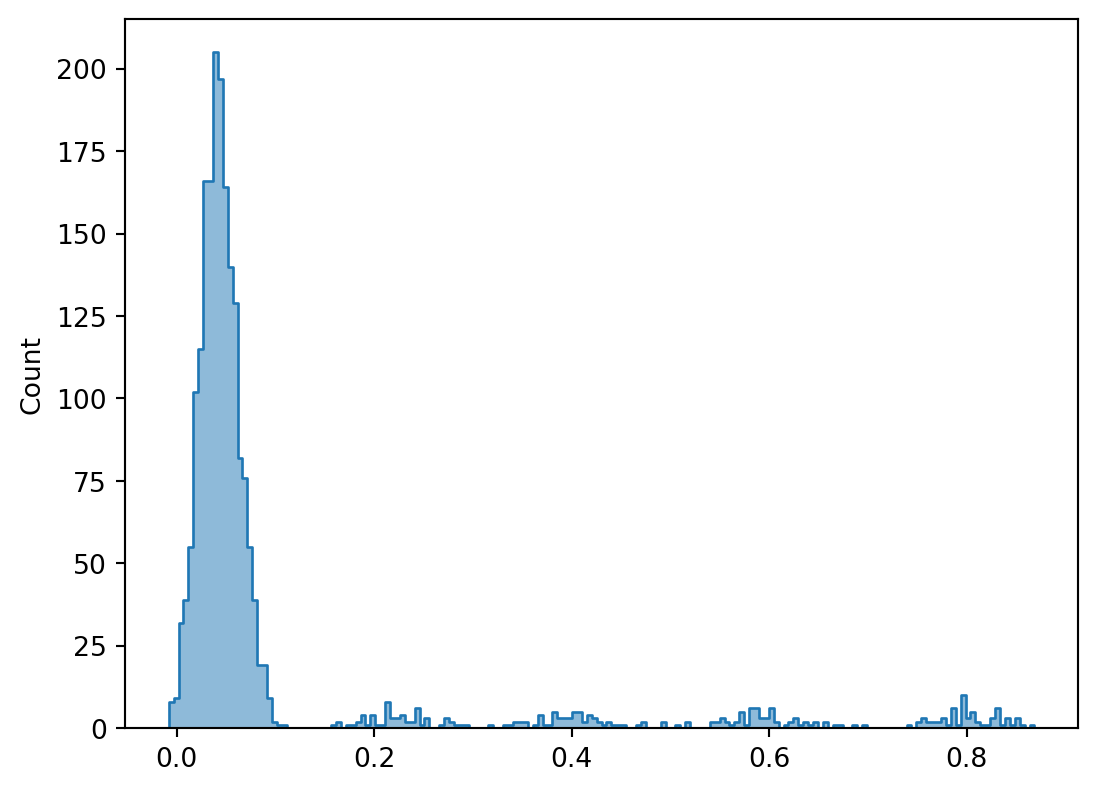

In [9]:
sns.histplot(sim_group.sim_fcd_trils[0], element='step', alpha=0.5)

### Check its goodness-of-fit to empirical data

Next, we will check the goodness-of-fit (GOF) of this example simulation to the empirical data. For this, we will use the example empirical BOLD time series included in the toolbox. This includes BOLD data which is cleaned and parcellated (using Schaefer-100).

<div class="alert alert-info">
<p>
Note: Tools such as [fMRIprep](https://fmriprep.org/en/stable/) + [XCP-D](https://xcp-d.readthedocs.io/en/latest/) or [Micapipe](https://micapipe.readthedocs.io/en/latest/) can be used to preprocess raw rs-fMRI data to such cleaned and parcellated BOLD data which is ready for comparison with the simulated BOLD signal.
</p>
</div>


We first load the example parcellated and cleaned empirical BOLD data and plot it:

Text(0.5, 1.0, 'Empirical BOLD')

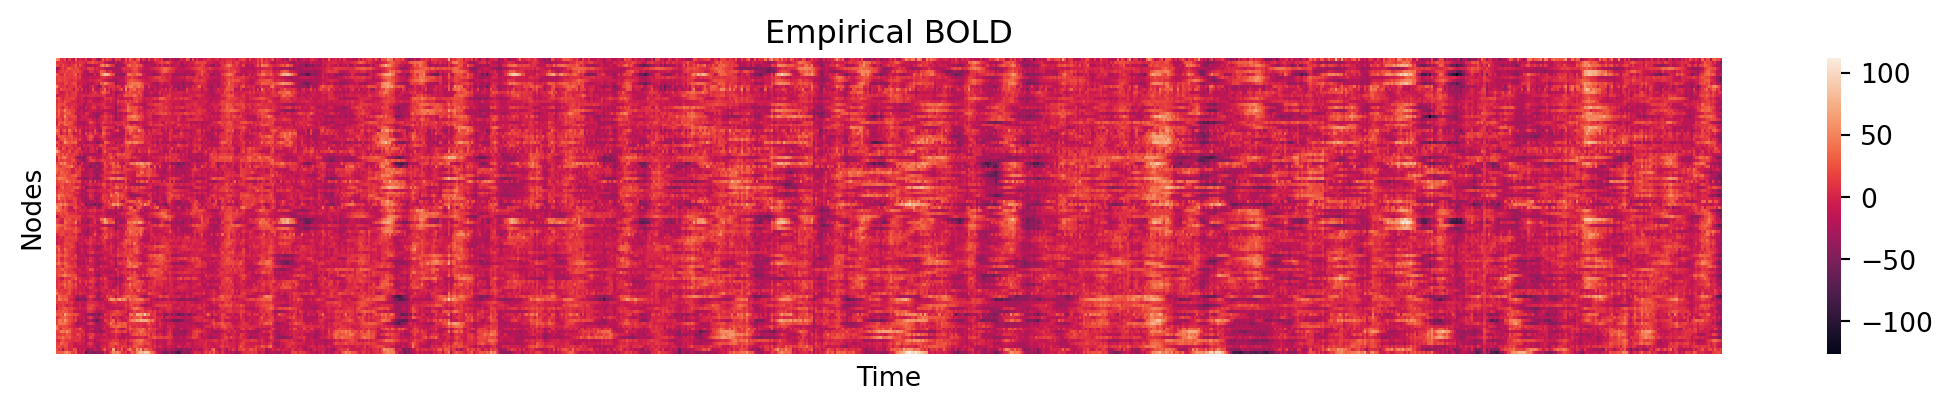

In [10]:
emp_bold = datasets.load_functional('bold', 'schaefer-100')

fig, ax = plt.subplots(figsize=(14, 2))
sns.heatmap(emp_bold, ax=ax)
ax.set_ylabel("Nodes")
ax.set_xlabel("Time")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Empirical BOLD")

From this empirical BOLD signal we can calculate empirical FC and FCD using `cubnm.utils` functions:

In [11]:
emp_fc = utils.calculate_fc(emp_bold, return_tril=False)
emp_fcd = utils.calculate_fcd(emp_bold, window_size=50, window_step=10, return_tril=False)

We can then plot the empirical FC next to the simulated FC we obtained above:

Text(0.5, 1.0, 'Simulated FC')

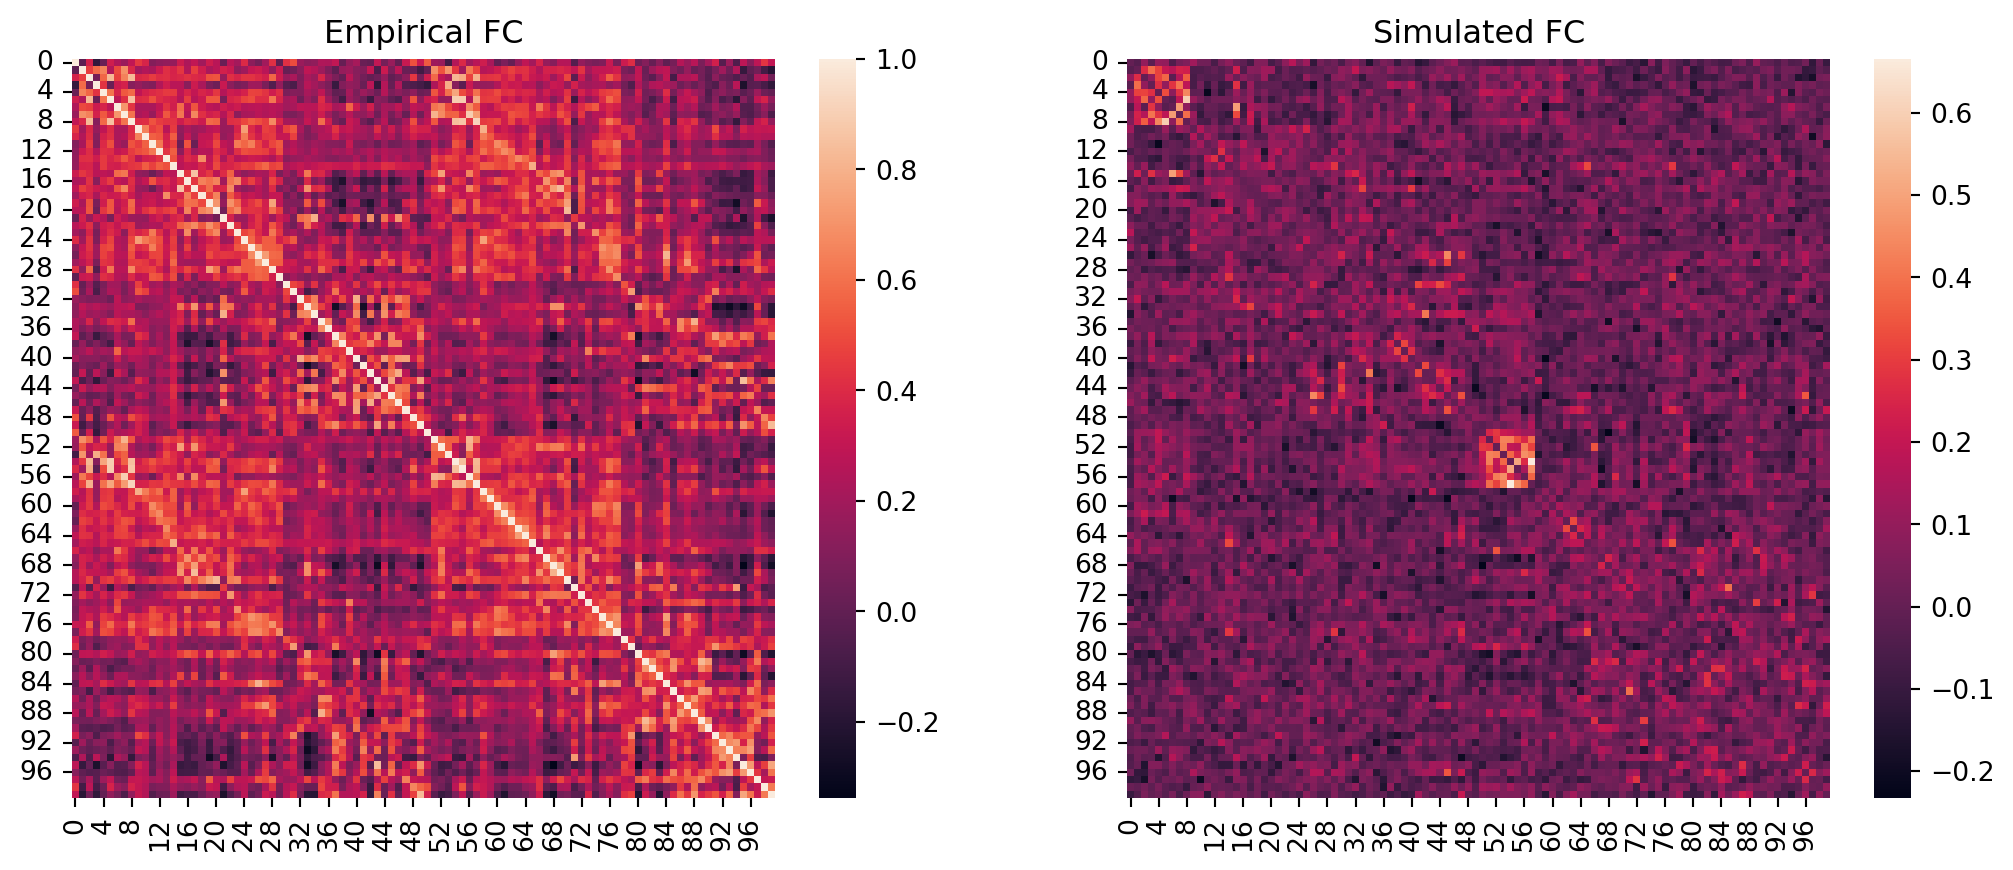

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(emp_fc, ax=axes[0])
axes[0].set_title("Empirical FC")
sns.heatmap(sim_fc, ax=axes[1])
axes[1].set_title("Simulated FC")

And check their similarity based on Pearson's correlation (of their lower triangles, again as they are symmetric matrices):

In [13]:
import scipy
scipy.stats.pearsonr(sim_group.sim_fc_trils[0], emp_fc[np.tril_indices_from(emp_fc, -1)]).statistic

0.20586107297094722

Typically we expect that this correlation is better, or at least close to the correlation of SC and empirical FC matrices (aka SC-FC coupling), which is:

In [14]:
scipy.stats.pearsonr(emp_fc[np.tril_indices_from(emp_fc, -1)], sc[np.tril_indices_from(sc, -1)]).statistic

0.2859787451097728

This indicates that this simulation does not have a very good GOF to the empirical data with respect to the similarity of FC patterns.

How about the dynamics?

For this, let's plot the empirical FCD next to the simulated FCD, and compare their distributions. We aim for a high similarity of the distributions, indicating similar levels of recurrence-vs-stability in dynamics.

Text(0.5, 1.0, 'Simulated FC')

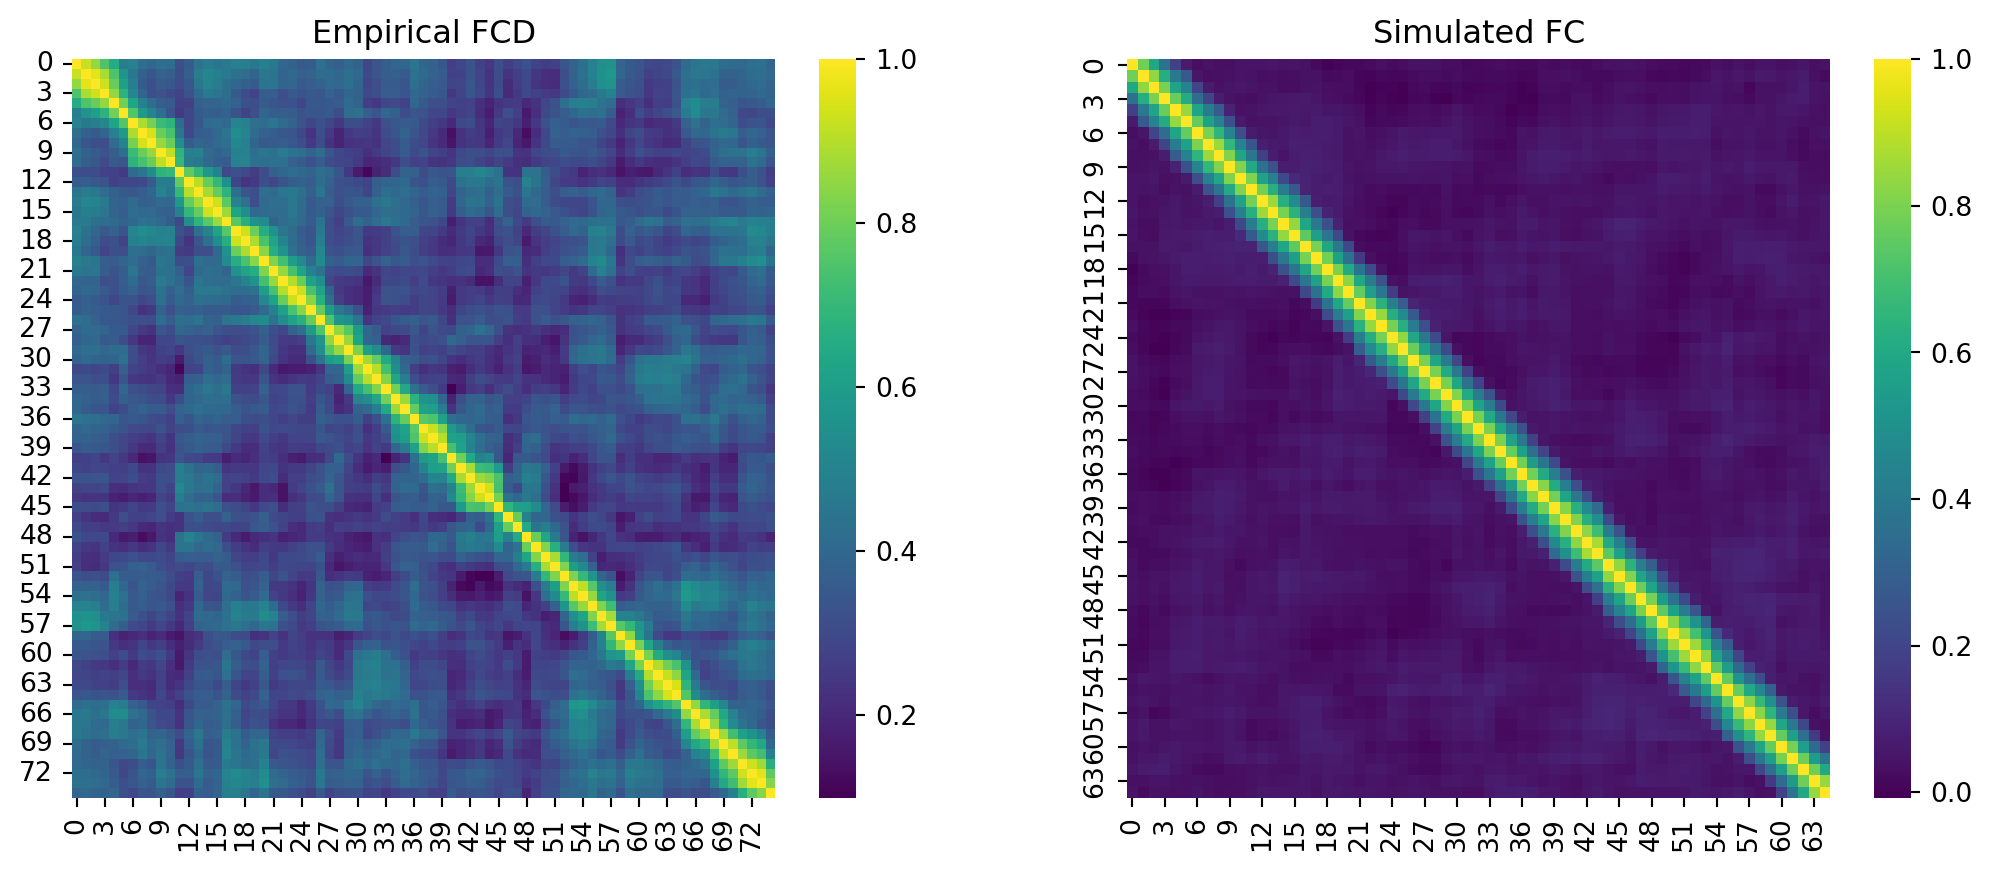

In [15]:
# matrices
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(emp_fcd, ax=axes[0], cmap='viridis')
axes[0].set_title("Empirical FCD")
sns.heatmap(sim_fcd, ax=axes[1], cmap='viridis')
axes[1].set_title("Simulated FC")

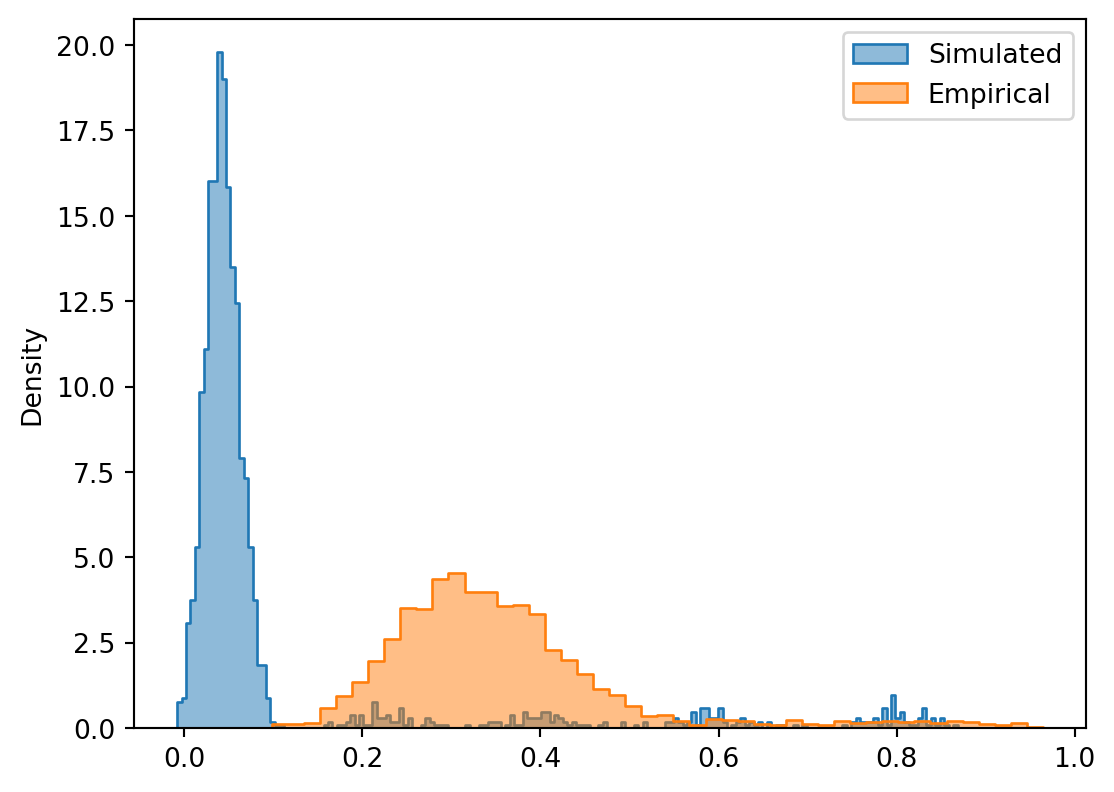

In [16]:
sns.histplot(sim_group.sim_fcd_trils[0], element='step', alpha=0.5, label='Simulated', stat='density')
ax = sns.histplot(emp_fcd[np.tril_indices_from(emp_fcd, -1)], element='step', alpha=0.5, label='Empirical', stat='density')

ax.legend()

The distributions do not look very similar. We can also quantify this by measuring the Kolmogorov-Smirnov (KS) distance of the FCD distributions (with lower values showing more similar distributions):

In [17]:
scipy.stats.ks_2samp(emp_fcd[np.tril_indices_from(emp_fcd, -1)], sim_group.sim_fcd_trils[0]).statistic

0.8783662508662509

The `sim_group` object has a method `.score` which given target empirical data (`emp_fc` and `emp_fcd`, or `emp_bold` from which FC and FCD will be calculated) can do the GOF calculations, and summarize them in a table, including the value of each GOF term, in addition to an overall GOF score resulted from summing up all the `gof_terms`.

In [18]:
sim_group.score(emp_bold=emp_bold)

+fc_corr   -fcd_ks      +gof  -fic_penalty
0  0.205861 -0.878366 -0.672505     -0.003469

<div class="alert alert-info">
<p>
Note: FIC penalty is a metric of how successful FIC was in keeping the mean firing rates across nodes close to 3 Hz. It is not included in `+gof` but will be considered in the optimization algorithms cost function. To disable it pass `fic_penalty=False` to the `cubnm.sim.rWWSimGroup` when setting it up. Note that FIC penalty is specific to rWW model.
</p>
</div>


As we can see, this example simulation does not have a very good fit to the empirical data. Therefore we will have to try other simulations after tuning the model parameters. In the next tutorials we will show how to use optimization algorithms to systematically do this. These optimization algorithms involve running (trying) many simulations, and the cuBNM toolbox offers great scalability of these simulations by using GPUs.